# Homework 07 Yifan(Crystal)CAI

Please submit an iPython notebook (.ipynb) file and an HTML version of the notebook (.html) to the Canvas assignment. Any other submission types (e.g. .py, only .ipynb) will be subject to a 10% deduction. Start this assignment early, as training models might take some time.

Word embeddings are a type of representation used in natural language processing (NLP) that allows words to be represented as dense vectors in a high-dimensional space. These vectors capture semantic and syntactic information about the words they represent, allowing NLP models to better understand the meaning of language.

Word2vec is a popular algorithm for training word embeddings. It works by analyzing the co-occurrence patterns of words in a large corpus of text, and learning to predict which words are likely to appear near each other.

#### Q1. In this part of the assignment, you will walk through a tutorial (https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.ZAeKny1h2M4). for generating word embeddings for a car and hotel reviews dataset (compiled from TripAdvisor and Edmunds). You will replicate the process to answer the following questions about the IMDB Movie Reviews dataset, which includes text from 50k reviews. Please include your code from walking through the tutorial. You don’t need to make any changes here, but make sure to understand the reasoning behind each step. Here’s http://jalammar.github.io/illustrated-word2vec/ another (optional) good resource on understanding the intuition behind Word2vec.

#### Q2. Pivoting to the IMDB Movie Reviews dataset, extract the reviews – what preprocessing techniques might you need to apply before the text can be ingested by word2vec? Split the data into training and test sets (80%-20% ratio suggested).

In [1]:
# !pip install -- upgrade tensorflow
# !pip install -U -q segmentation-models
# !pip install -q tensorflow
# !pip install -q keras
# !pip install -q tensorflow-estimator

In [2]:
import csv
import gensim
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Input, Flatten, Conv1D, MaxPooling1D
from gensim.models import KeyedVectors

In [3]:
# Input file 
input_file = '/Users/crystal/Desktop/assign07_0313/IMDB Dataset.csv'

In [4]:
# Load the dataset into a pandas dataframe
df = pd.read_csv(input_file)
# Extract the review texts and sentiment labels
reviews = df['review'].tolist()
labels = df['sentiment'].tolist()

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# Tokenize and preprocess the reviews
def read_input(input_file):
    # Read in file avoid reading the column names
    with open(input_file, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            yield gensim.utils.simple_preprocess(row['review'])

In [7]:
documents = list(read_input(input_file))

#### Q3. The Word2vec module is available directly in Python from the library gensim. Notice that there are several parameters you can customize (size, window, min_count, sg). By default, size (defining the output vector dimensions) is set to 100, window to 5, min_count to 5, and sg to 0 (i.e. continuous bag of words). After developing your embeddings, you will use them as an input into downstream models – in this case, logistic regression for all subparts for sentiment analysis. Make sure to use sg = 1 (specifying skip-gram) for all models in this assignment.

1. Maintaining the default parameters (except sg = 1), generate word embeddings of dimension 100. For each review, average the embedding vectors for each word to create an overall vector representing its text. Now, rerun logistic regression to classify each review. How have your accuracies changed?

In [8]:
# Build vocabulary and train model
model = gensim.models.Word2Vec(documents,vector_size=100,window=5,min_count=5,sg = 1,workers=10)

In [9]:
# Create empty numpy array for reviews embeddings
reviews_embeddings = np.zeros((len(documents), 100))

In [10]:
# Loop through each review
for i, review in enumerate(documents):
    words_embeddings = []
    # loop through each word in the review
    for word in review:
        # if the word is in the model vocabulary, append its embedding to words_embeddings
        if word in model.wv.key_to_index:
            words_embeddings.append(model.wv[word])
    # calculate the mean embedding for the review and store it in reviews_embeddings
    if words_embeddings:
        mean_embedding = np.mean(words_embeddings, axis=0)
        reviews_embeddings[i] = mean_embedding

In [11]:
# Use reviews_embeddings as the input to logistic regression to classify each review.
X_train, X_test, y_train, y_test = train_test_split(reviews_embeddings, labels, test_size=0.2, random_state=42)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.870275
Test accuracy: 0.8667


2. Maintaining all other parameters as defaults, vary size between [25, 50, 100, 150]. Plot size vs. train and test accuracy. Briefly comment on how changing this parameter impacts model performance, intuitively as well as specifically for this dataset.

In [12]:
# Initialize empty lists to store accuracies
train_accs = []
test_accs = []

# Define vector sizes to test
vector_sizes = [25, 50, 100, 150]

for vector_size in vector_sizes:
    # Build vocabulary and train model
    model = gensim.models.Word2Vec(documents,vector_size=vector_size,window=5,min_count=5,sg = 1,workers=10)
    
    # Create empty numpy array for reviews embeddings
    reviews_embeddings = np.zeros((len(documents), vector_size))
    
    # Loop through each review
    for i, review in enumerate(documents):
        words_embeddings = []
        # loop through each word in the review
        for word in review:
            # if the word is in the model vocabulary, append its embedding to words_embeddings
            if word in model.wv.key_to_index:
                words_embeddings.append(model.wv[word])
        # calculate the mean embedding for the review and store it in reviews_embeddings
        if words_embeddings:
            mean_embedding = np.mean(words_embeddings, axis=0)
            reviews_embeddings[i] = mean_embedding
    
    # Use reviews_embeddings as the input to logistic regression to classify each review.
    X_train, X_test, y_train, y_test = train_test_split(reviews_embeddings, labels, test_size=0.2, random_state=42)

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)

    train_acc = lr.score(X_train, y_train)
    test_acc = lr.score(X_test, y_test)
    
    # Append accuracies to lists
    train_accs.append(train_acc)
    test_accs.append(test_acc)

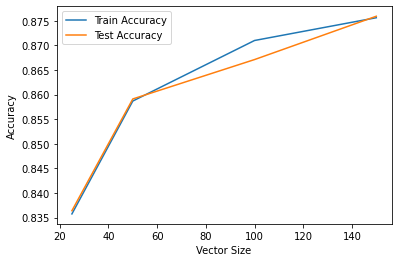

In [13]:
# Plot size vs. train and test accuracy
plt.plot(vector_sizes, train_accs, label='Train Accuracy')
plt.plot(vector_sizes, test_accs, label='Test Accuracy')
plt.xlabel('Vector Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3. Similarly, vary the window between [2, 3, 5, 10], and answer the same questions as (b).

In [14]:
# Initialize empty lists to store accuracies
train_accs = []
test_accs = []

# Define window sizes to test
window_sizes = [2, 3, 5, 10]

for window_size in window_sizes:
    # Build vocabulary and train model
    model = gensim.models.Word2Vec(documents, vector_size=100, window=window_size, min_count=5, sg=1, workers=10)
    
    # Create empty numpy array for reviews embeddings
    reviews_embeddings = np.zeros((len(documents), 100))
    
    # Loop through each review
    for i, review in enumerate(documents):
        words_embeddings = []
        # loop through each word in the review
        for word in review:
            # if the word is in the model vocabulary, append its embedding to words_embeddings
            if word in model.wv.key_to_index:
                words_embeddings.append(model.wv[word])
        # calculate the mean embedding for the review and store it in reviews_embeddings
        if words_embeddings:
            mean_embedding = np.mean(words_embeddings, axis=0)
            reviews_embeddings[i] = mean_embedding
    
    # Use reviews_embeddings as the input to logistic regression to classify each review.
    X_train, X_test, y_train, y_test = train_test_split(reviews_embeddings, labels, test_size=0.2, random_state=42)

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)

    train_acc = lr.score(X_train, y_train)
    test_acc = lr.score(X_test, y_test)
    
    # Append accuracies to lists
    train_accs.append(train_acc)
    test_accs.append(test_acc)

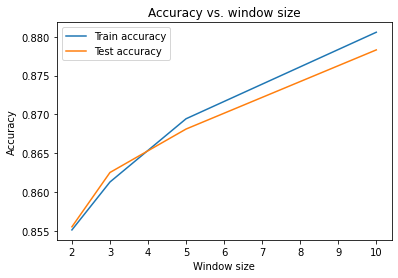

In [15]:
# Plot size vs. train and test accuracy
plt.plot(window_sizes, train_accs, label="Train accuracy")
plt.plot(window_sizes, test_accs, label="Test accuracy")
plt.xlabel("Window size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. window size")
plt.legend()
plt.show()

#### Q4. For this part, your downstream model for sentiment analysis will evolve from simple logistic regression to a recurrent neural network architecture. For the Word2Vec embedding model, use the trained model with all default parameters except size, which will be set to 300, for this part. 

1. Why would you want to use an RNN for sentiment analysis or text classification tasks instead of models that aren’t neural networks e.g. logistic regression?

**Answer :** <br>
RNNs are useful for text classification tasks such as sentiment analysis because they can capture the sequential nature of language. Unlike logistic regression, which treats each word in a sentence as an independent feature, RNNs can take into account the entire sequence of words in a sentence, along with their order and context, to make more accurate predictions. This is especially important for tasks like sentiment analysis, where the sentiment of a sentence can be influenced by the context of the words used. Additionally, RNNs can handle variable-length input sequences, which is necessary for text classification tasks where the length of the input text can vary from one example to another.

2. Use Keras to build a neural network classifier. Here (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) is a helpful walkthrough to understand the input transformation and model building process with pre-trained embeddings. We will use a simple architecture. 
- Use the Keras tokenizer and text_to_sequences function to transform each review into an integer sequence. This maps each word to a unique index, which can serve as an identifier. Use pad_sequences with a maximum length corresponding to the longest review to ensure that each input vector into the neural network is of the same length.
- Modify the code at the bottom of the assignment according to your implementation from (1) to create your RNN in Keras.
- Fit the training data over 10 epochs, and measure both train and test accuracy. Note that training might take some time. 
- Compare the performance of the RNN to the previous model (word2vec followed by logistic regression). Do word embeddings generally perform better in practice than frequency-based transformations? 

In [92]:
X = df['review']
y = df['sentiment']

In [95]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create tokenizer and fit on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_len = max([len(x) for x in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Get vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1

embedding_size = 300

In [103]:
# Create model
model_01 = Sequential()
model_01.add(Embedding(vocabulary_size, embedding_size, input_length=max_len))
model_01.add(LSTM(embedding_size))
model_01.add(Dense(1, activation='sigmoid'))

# Compile model
model_01.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [105]:
model_01.save('my_model01.h5')

In [104]:
# Train model
model_01.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=64)

# Evaluate model
train_loss, train_acc = model_01.evaluate(X_train_pad, y_train, verbose=0)
test_loss, test_acc = model_01.evaluate(X_test_pad, y_test, verbose=0)

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node 'binary_crossentropy/Cast' defined at (most recent call last):
    File "/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-104-62f7427e259d>", line 2, in <module>
      model_01.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=64)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 2165, in binary_crossentropy
      y_true = tf.cast(y_true, y_pred.dtype)
Node: 'binary_crossentropy/Cast'
Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_55715]

In [17]:
# Tokenize reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

# Pad sequences to ensure they are all the same length
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length)

# Create labels
y = np.array(df['sentiment'].map({'positive': 1, 'negative': 0}))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3. Fortunately, gensim also gives us access to several pre-trained models – use word2vec-google-news-300, which will provide you with 300-dimensional embedding vectors. Use these as inputs to the RNN architecture you created in the previous exercise, making sure to redo the embedding layer with the different weights. Compare the performance of the model (train, test accuracy) with pre-trained embeddings to the previous one you created with embeddings specifically trained on your corpus.

In [106]:
## Preparing the Embedding layer
# Compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:
embeddings_index = {}
f = open(os.path.join('/Users/crystal/Desktop/assign07_0313/', 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [107]:
#Leverage embedding_index dictionary and word_index to compute embedding matrix:
word_index = tokenizer.word_index
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [108]:
# We load this embedding matrix into an Embedding layer. 
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [109]:
# Build the model with pre-trained embeddings
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(300))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy']) 

In [ ]:
model.save('my_model02.h5')

In [72]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Evaluate the model on test data 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
250/250 [==============================] - 34969s 140s/step - loss: 0.5781 - accuracy: 0.7018 - val_loss: 0.4568 - val_accuracy: 0.7996
Epoch 2/10
250/250 [==============================] - 23519s 94s/step - loss: 0.4723 - accuracy: 0.7855 - val_loss: 0.4463 - val_accuracy: 0.7951
Epoch 3/10
250/250 [==============================] - 9491s 38s/step - loss: 0.3806 - accuracy: 0.8351 - val_loss: 0.3238 - val_accuracy: 0.8664
Epoch 4/10
250/250 [==============================] - 11845s 47s/step - loss: 0.3193 - accuracy: 0.8648 - val_loss: 0.2913 - val_accuracy: 0.8767
Epoch 5/10
250/250 [==============================] - 10130s 41s/step - loss: 0.2875 - accuracy: 0.8812 - val_loss: 0.2731 - val_accuracy: 0.8841
Epoch 6/10
250/250 [==============================] - 5844s 23s/step - loss: 0.2619 - accuracy: 0.8917 - val_loss: 0.2612 - val_accuracy: 0.8913
Epoch 7/10
250/250 [==============================] - 5620s 22s/step - loss: 0.2415 - accuracy: 0.9021 - val_loss: 0.2588 - v

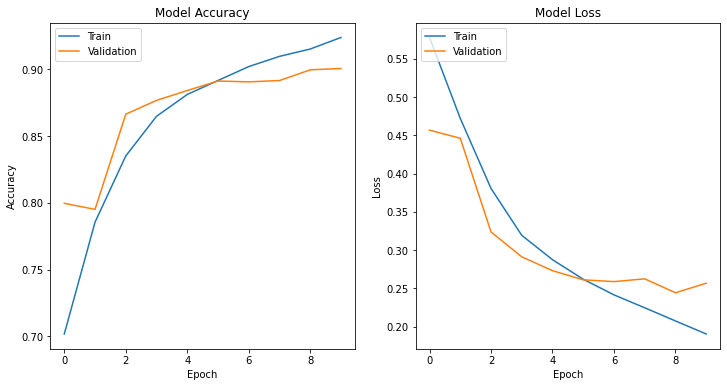

In [81]:
# Set figure size
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

3. Fortunately, gensim also gives us access to several pre-trained models – use word2vec-google-news-300, which will provide you with 300-dimensional embedding vectors. Use these as inputs to the RNN architecture you created in the previous exercise, making sure to redo the embedding layer with the different weights. Compare the performance of the model (train, test accuracy) with pre-trained embeddings to the previous one you created with embeddings specifically trained on your corpus.

In [83]:
# Load pre-trained word2vec-google-news-300 embeddings
import gensim
model_path = '/Users/crystal/Desktop/assign07_0313/GoogleNews-vectors-negative300.bin.gz'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [85]:
# Tokenize reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

# Pad sequences to ensure they are all the same length
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length)

# Create labels
y = np.array(df['sentiment'].map({'positive': 1, 'negative': 0}))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preparing the Embedding layer
# Compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:
EMBEDDING_DIM = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in w2v_model.key_to_index:
        embedding_matrix[i] = w2v_model.get_vector(word)

# We load this embedding matrix into an Embedding layer. 
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [88]:
## Building the RNN model
w2v_model = Sequential()
w2v_model.add(embedding_layer)
w2v_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
w2v_model.add(Dense(1, activation='sigmoid'))

w2v_model.compile(loss='binary_crossentropy',metrics=['accuracy'])

**Note :** As each epoch takes around 2-3 hours to run and It already took me four days to finish the previous part and run the previous model with 10 epochs. So I don't have enough time to run full 10 epoches before deadline of this assignment and I just ran 3 epoches. Therefore, the result (accuracy) of the pre-trained model might not be suitable to be compared with the previous model as it's only trained for three epoches.

In [90]:
# Train model 
w2v_history = w2v_model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)

# Evaluate model on test data 
w2v_test_loss, w2v_test_acc = w2v_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/3
 79/250 [========>.....................] - ETA: 1:51:24 - loss: 0.6221 - accuracy: 0.6680

KeyboardInterrupt: 

In [ ]:
# Set figure size
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

4. In this assignment, you (1) trained your own Word2Vec model with the IMDB Movie Reviews corpus, and (2) used pre-trained Word2Vec embeddings in downstream sentiment analysis tasks. Now, focusing on the generated 300-dimensional embeddings, we will visualize the words occurring in the dataset.
- First, for the word “interesting,” find the 20 most similar words according to model (1) and model (2). Do the same for “boring.” Are there any differences in the lists generated by each model?
- Use PCA to reduce the number of dimensions from 300, picking a number of dimensions that retains 75% of the cumulative explained variance.
- Find the first and second principal components. For “interesting,” “boring,” and all unique words you found in part (a) across both models, plot PC 1 vs. PC 2, and analyze the resulting visualization.

In [ ]:
# Find most similar words to "interesting" and "boring" for model (1)
most_similar_glove_interesting = model.most_similar('interesting', topn=20)
most_similar_glove_boring = model.most_similar('boring', topn=20)

# Find most similar words to "interesting" and "boring" for model (2)
most_similar_word2vec_interesting = w2v_model.most_similar('interesting', topn=20)
most_similar_word2vec_boring =  w2v_model.most_similar('boring', topn=20)

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality of word embeddings with PCA
pca = PCA(n_components=0.75)
pca.fit(embedding_matrix)
embedding_matrix_pca = pca.transform(embedding_matrix)

In [ ]:
# Define words to plot
words_to_plot = ['interesting', 'boring']
for word, sim_words in [('interesting', most_similar_glove_interesting),
                        ('boring', most_similar_glove_boring),
                        ('interesting', most_similar_word2vec_interesting),
                        ('boring', most_similar_word2vec_boring)]:
    for sim_word, _ in sim_words:
        if sim_word not in words_to_plot:
            words_to_plot.append(sim_word)

# Get PCA coordinates for each word
word_coords = {}
for word in words_to_plot:
    if word in pca_dict:
        word_coords[word] = pca_dict[word]
    else:
        word_coords[word] = pca.transform([embedding_matrix[word_index[word]]])[0]

In [ ]:
# Plot first and second principal components for each word
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding_matrix_pca[:,0], embedding_matrix_pca[:,1], alpha=0.1, color='gray')
for word, coords in word_coords.items():
    ax.annotate(word, coords)
    if word in ['interesting', 'boring']:
        ax.scatter(coords[0], coords[1], color='red')
plt.show()